# Quantum teleportation using feed-forward

The goal of this notebook is to use perceval's feed-forward ability to demonstrate the quantum teleportation algorithm \[1\] on a photonic simulated circuit using dual rail encoding.

## I. Definition of the problem

The idea of the protocol is the following:

Say that Alice has a generic qubit of the form

$$|\psi\rangle = \alpha |0\rangle + \beta |1\rangle \;$$

that they want to send to a distant receiver called Bob. Since Bob is distant, we want to avoid transporting physical systems from Alice to Bob (only classical light will do).

Before the start of the algorithm, Alice and Bob need to share a maximally entangled Bell state. For this example, we choose

$$|\phi^+\rangle = \frac{1}{\sqrt{2}} (|0_A 0_B\rangle + |1_A 1_B\rangle) \;$$

The first qubit is accessible to Alice and the second to Bob. We now drop the subscript $A$ and $B$ for clarity. 

The composite system is then

$$|\psi\rangle \otimes |\phi^+\rangle = (\alpha |0\rangle + \beta |1\rangle) \otimes \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$$

The algorithm is the following:

Alice performs a CNOT using the first qubit as control and the second as target, then applies a Hadamard gate to the first qubit.

![quantum_teleportation_circuit](../_static/img/quantum_teleportation_circuit.jpg)

At the end, the composite system can be written as

\begin{align}
& \frac{1}{2}|00\rangle \otimes (\alpha |0\rangle + \beta |1\rangle) \\
+& \frac{1}{2}|01\rangle \otimes (\beta |0\rangle + \alpha |1\rangle) \\
+& \frac{1}{2}|10\rangle \otimes (\alpha |0\rangle - \beta |1\rangle) \\
+& \frac{1}{2}|11\rangle \otimes (- \beta |0\rangle + \alpha |1\rangle)
\end{align}

Then Alice measures their two qubits and send the results to Bob using a classical channel.
Firstly, if the second qubit is measured to be 1, Bob needs to apply a X gate to their qubit.
Then, if the first qubit is measured to be 1, Bob needs to apply a Z gate to their qubit.

After these corrections, Bob's qubit is guaranteed to be the original qubit of Alice $|\psi\rangle$.

## II. Translation to Perceval

In [1]:
import numpy as np

import perceval as pcvl
from perceval import catalog

### Starting state

First, we need to create the input state $|\psi\rangle \otimes |\phi^+\rangle$ for this algorithm. For demonstration purpose, we choose $\alpha$ and $\beta$ randomly.

In [2]:
# Creation of the qubit to transmit
alpha = np.random.random()
beta = np.random.random() * np.exp(2 * np.pi * 1j * np.random.random())
# alpha |0> + beta |1> in dual rail encoding
to_transmit = pcvl.BasicState([1, 0]) * alpha + pcvl.BasicState([0, 1]) * beta
to_transmit.normalize()

alpha = to_transmit[pcvl.BasicState([1, 0])]  # Normalized
beta = to_transmit[pcvl.BasicState([0, 1])]

print(to_transmit)

0.974*|1,0>+(-0.087+0.207I)*|0,1>


In [3]:
# Creation of the quantum channel
sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")
print(bell_state)

0.707*|1,0,1,0>+0.707*|0,1,0,1>


In [4]:
input_state = to_transmit * bell_state

### Tomography

Since we will only return probabilities and not quantum amplitudes, we will not have access to the relative phase between $|0\rangle$ and $|1\rangle$. However, we saw in the paragraph that, we need correction to teleport the state. Because we want to see the correctness of the teleportation, we code below a state tomography for 1 qubit to be able to make we have teleported the correct state.

Since a qubit is defined up to a global rotation, we consider that $\alpha$ is a real non-negative number.

In [5]:
# Needed if the number of modes is bigger than 2
def squash_results(res: pcvl.BSDistribution, first_mode: int) -> pcvl.BSDistribution:
    """Sum the output probabilities to keep only the mode of interest and the following"""
    bsd = pcvl.BSDistribution()
    for state, prob in res.items():
        bsd[state[first_mode:first_mode+2]] += prob

    return bsd

def tomography(processor: pcvl.Processor, first_mode: int = 0) -> pcvl.StateVector:
    # First using identity, we get alpha ** 2 and |beta| ** 2
    res = processor.probs()["results"]
    res = squash_results(res, first_mode)

    alpha = res[pcvl.BasicState([1, 0])] ** .5
    if alpha == 0:
        return pcvl.StateVector(pcvl.BasicState([0, 1]))

    processor = processor.copy()
    # We do the same, but we add a H gate at the end for the qubit we are interested in
    processor.add(first_mode, pcvl.BS.H())
    res = processor.probs()["results"]
    res = squash_results(res, first_mode)

    p0 = res[pcvl.BasicState([1, 0])]  # 1/2 |alpha + beta| ** 2
    p1 = res[pcvl.BasicState([0, 1])]  # 1/2 |alpha - beta| ** 2

    # By writing beta = x + i y, we get
    x = (p0 - p1) / (2 * alpha)

    processor = processor.copy()
    # We do the same, but we multiply by i the amplitudes of qubit |1> before applying the H gate
    processor.add(first_mode + 1, pcvl.PS(np.pi / 2))
    processor.add(first_mode, pcvl.BS.H())
    res = processor.probs()["results"]
    res = squash_results(res, first_mode)

    p0 = res[pcvl.BasicState([1, 0])]  # 1/2 |alpha + i beta| ** 2
    p1 = res[pcvl.BasicState([0, 1])]  # 1/2 |alpha - i beta| ** 2

    y = (p0 - p1) / (2 * alpha)
    beta = x + 1j * y

    return alpha * pcvl.BasicState([1, 0]) + beta * pcvl.BasicState([0, 1])

We can now test this algorithm on our original qubit using an identity circuit.

In [6]:
p = pcvl.Processor("SLOS", 2)

p.min_detected_photons_filter(1)
p.with_input(to_transmit)

tomography(p)

0.974*|1,0>+(-0.087+0.207I)*|0,1>

We get the same state so the tomography process works.

### Circuit

Now we need to define the circuit on which the operations will take place. Since we need to use quantum gates and feed-forward operations, we need to use a `Processor` object.

First, we define the photonic circuit that applies on the qubits. We have 3 qubits hence we need a processor with 6 modes.

Since the qubits on which the CNOT is applied will only perform 1-qubit gates *in the quantum circuit*, we can use a postprocessed CNOT instead of a heralded CNOT.

In [7]:
p = pcvl.Processor("SLOS", 6)
p.add(0, catalog["postprocessed cnot"].build_processor())
p.add(0, pcvl.BS.H());

Now we need to add the feed-forwarded components. For this purpose, Perceval uses two configurators that link measures to circuits or processors.

Both of them need to be defined by the number of modes they measure, the number of empty modes between the measured modes and the circuit they configure (this is an integer called `offset`), and a default configuration that is used whenever a measure does not befall into one of the cases that were defined when creating the object.

The measured modes need to be classical modes. Thus, we need to add detectors before adding the configurators.

The X gate corresponds to a permutation for a dual rail encoding if we measure $|1\rangle$, or an empty circuit if we measure $|0\rangle$. Thus, we are going to use a `FFCircuitProvider` as it links a measured state to a circuit or a processor.

In [8]:
# 2 measured modes
# offset = 0 means that there is 0 empty modes between the measured modes and the circuit
# the default circuit is an empty circuit
ff_X = pcvl.FFCircuitProvider(2, 0, pcvl.Circuit(2))

# Now if we measure a logical state |1>, we need to perform a permutation of the modes
ff_X.add_configuration([0, 1], pcvl.PERM([1, 0]))

# Add perfect detectors to the modes that will be measured
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())
p.add(2, ff_X);

The Z gate corresponds to a $\pi$ shift on the second mode. Thus, we are going to use a `FFConfigurator` that uses a parametrized circuit and links the measured states to a mapping of values for these parameters.

In [9]:
phi = pcvl.P("phi")
# Like Circuits and Processors, we can chain the `add` methods
ff_Z = pcvl.FFConfigurator(2, 3, pcvl.PS(phi), {"phi": 0}).add_configuration([0, 1], {"phi": np.pi})

p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())
p.add(0, ff_Z);

We can check that we defined correctly our processor. Note that using the `recursive=True` flag, we can expose the inner circuit of the `FFConfigurator`.

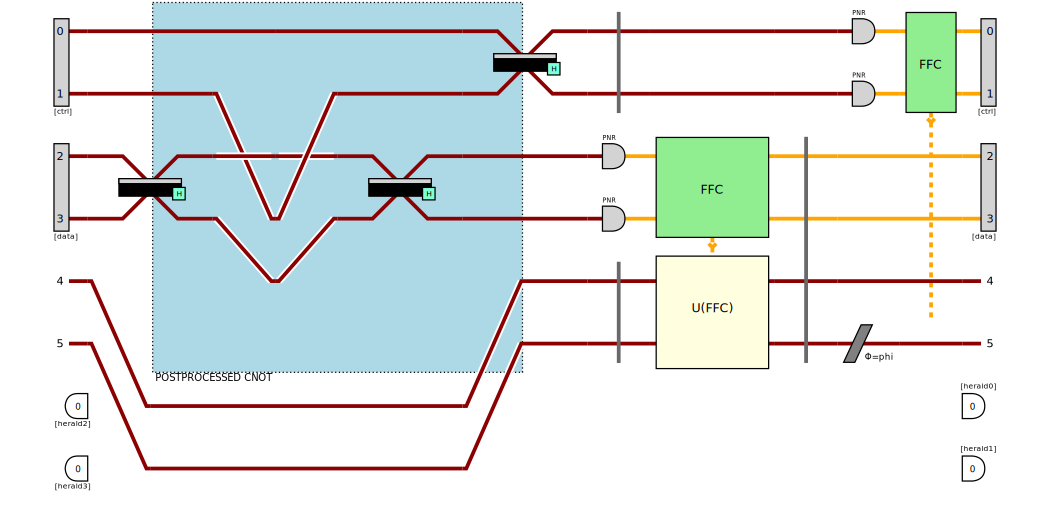

In [10]:
pcvl.pdisplay(p, recursive=True)

## III. Simulation

Now that we have both the input state and the processor, we can run the algorithm and check that it works.

In [11]:
p.min_detected_photons_filter(3)

# Since we use a "custom" (understand not a BasicState) input state,
# we have to add the heralds from the post-processed cnot manually
input_state *= pcvl.BasicState([0, 0])

p.with_input(input_state)

res = p.probs()
print(res)

{'results': {
	|1,0,0,1,1,0>: 0.207498095837542
	|1,0,1,0,1,0>: 0.20749809583754203
	|0,1,0,1,1,0>: 0.29250190416245797
	|0,1,1,0,1,0>: 0.29250190416245797
}, 'global_perf': 1.0000000000000002}


Notice that when using feed-forward, the performance indicators are replaced by a single indicator "global_perf", which represents the probability that an output state checks all requirements. In our case, this corresponds to the CNOT gate performance: $1 / 9 \approx 0.111$.

For the results, we don't need to know what was measured by Alice, so we need to squash the resulting probabilities to keep only the two last modes.

In [12]:
print(squash_results(res["results"], 4))

{
	|1,0>: 1
}


We can now apply our tomography process to check that Bob's qubit is now the initial qubit that Alice wanted to transmit.

In [13]:
print(tomography(p, 4))

|1,0>


Tadaaaa! We get the state that we wanted to transmit. Pretty to cool to teleport state in photonics right?

## References

> [1] C. H. Bennett, G. Brassard, C. Crépeau, R. Jozsa, A. Peres and W. K. Wootters, “Teleporting an unknown quantum state via dual classical and Einstein-Podolsky-Rosen channels”, [Phys. Rev. Lett.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895) **70**, 1895 (1993).